In [ ]:
import torch
import numpy as np
import torch.utils.data as data

import anndata as ad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score
from tqdm import tqdm
from clearml import Logger
import clearml
from clearml import Taskfrom
import os
from get_api_keys import get_secret

In [2]:
from model import RNAseqClassifier, get_model_and_optimizer
from dataset import scRNAseqDataset
from train import train_model
from utils import compute_metrics, predict_sample

In [ ]:
adata_1200 =  ad.read_h5ad('DATA/ANNDATAS/adata_scanvi_1200.h5ad')
adata_4369 = ad.read_h5ad('DATA/ANNDATAS/adata_scanvi_4369.h5ad')

In [ ]:
raw_adata =  ad.read_h5ad('DATA/GSE155249_COUNTS_NOT_NORMALIZED.h5ad')
raw_adata

AnnData object with n_obs × n_vars = 77146 × 1200
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cluster_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
os.environ["CLEARML_API_ACCESS_KEY"] = get_secret("CLEARML_API_ACCESS_KEY")
os.environ["CLEARML_API_SECRET_KEY"] = get_secret("CLEARML_API_SECRET_KEY")

clearml.browser_login()

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=XXQMNQA0L2KFEQ543XAX5I84ZUPS6Q
env: CLEARML_API_SECRET_KEY=BQtU7Xi6tuKz7ypMjSijeX8l2NmcP6ZWtcVdOJREAfhI7cEZL1SyT94lL585_Vy9M5Y


In [5]:
cells = adata_1200.obs_names
y = adata_1200.obs['Cluster'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

cells_train, cells_temp, y_train, y_temp = train_test_split(
    cells, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

cells_val, cells_test, y_val, y_test = train_test_split(
    cells_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 15

In [7]:
adata_1200

AnnData object with n_obs × n_vars = 77146 × 1200
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cluster_colors', 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
adata_4369

AnnData object with n_obs × n_vars = 77146 × 4369
    obs: 'barcode_name', 'Sample', 'Cluster', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'X_scANVI', 'X_scVI'
    layers: 'counts'

In [9]:
LR = 0.007

### SCVI

In [10]:
torch.manual_seed(111)

for adata, adata_name in zip([adata_1200, adata_4369], ['1200_scVI', '4369_scVI']):

    n_hvgs = adata.shape[1]

    X_train = adata[cells_train].obsm['X_scVI']
    X_val = adata[cells_val].obsm['X_scVI']
    # X_test = adata[cells_test].obsm['X_scVI']

    train_dataset = scRNAseqDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = scRNAseqDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=True)

    model, optimizer = get_model_and_optimizer(
        input_size=X_train.shape[1],
        output_size=len(np.unique(y_train)),
        layer_config=None,
        lr=LR,
        weight_decay=0.00001
    )

    task = Task.init(project_name='Modelling', task_name=f'{adata_name}')

    print("start training")

    train_model(
        model=model,
        model_name=f"{adata_name}",
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        task=task
    )

    task.close()

ClearML Task: created new task id=47ebbb675434461393cb16a0b37451c4
2025-06-19 22:29:16,326 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2025-06-19 22:29:16,327 - clearml.Repository Detection - WARNING - Please install nbconvert using "pip install nbconvert"
2025-06-19 22:29:16,871 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/47ebbb675434461393cb16a0b37451c4/output/log
start training


Initial Validation: 100%|██████████| 121/121 [00:07<00:00, 16.39it/s]
1200_scVI | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:35<00:00, 12.01it/s] 
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1027.70it/s]


Epoch 1/15 | Train Acc: 0.7600 | Val Acc: 0.8235 | Train F1: 0.6798 | Val F1: 0.8003


1200_scVI | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 352.92it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 995.12it/s]


Epoch 2/15 | Train Acc: 0.7932 | Val Acc: 0.8280 | Train F1: 0.7768 | Val F1: 0.8313


1200_scVI | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 330.87it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 961.46it/s]


Epoch 3/15 | Train Acc: 0.7981 | Val Acc: 0.8310 | Train F1: 0.7882 | Val F1: 0.8555


1200_scVI | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 320.97it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1015.01it/s]


Epoch 4/15 | Train Acc: 0.8028 | Val Acc: 0.8310 | Train F1: 0.8005 | Val F1: 0.8337


1200_scVI | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 369.59it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 942.16it/s]


Epoch 5/15 | Train Acc: 0.8047 | Val Acc: 0.8293 | Train F1: 0.8021 | Val F1: 0.8329


1200_scVI | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 324.20it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1040.54it/s]


Epoch 6/15 | Train Acc: 0.8060 | Val Acc: 0.8357 | Train F1: 0.8107 | Val F1: 0.8273


1200_scVI | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 348.44it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 888.61it/s]


Epoch 7/15 | Train Acc: 0.8077 | Val Acc: 0.8363 | Train F1: 0.8109 | Val F1: 0.8502


1200_scVI | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 320.03it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1040.25it/s]


Epoch 8/15 | Train Acc: 0.8079 | Val Acc: 0.8367 | Train F1: 0.8185 | Val F1: 0.8416


1200_scVI | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 368.13it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1007.58it/s]


Epoch 9/15 | Train Acc: 0.8092 | Val Acc: 0.8310 | Train F1: 0.8152 | Val F1: 0.8432


1200_scVI | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 360.60it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1005.26it/s]


Epoch 10/15 | Train Acc: 0.8096 | Val Acc: 0.8343 | Train F1: 0.8195 | Val F1: 0.8559


1200_scVI | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 368.91it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1003.49it/s]


Epoch 11/15 | Train Acc: 0.8096 | Val Acc: 0.8351 | Train F1: 0.8170 | Val F1: 0.8472


1200_scVI | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 363.46it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1021.58it/s]


Epoch 12/15 | Train Acc: 0.8123 | Val Acc: 0.8346 | Train F1: 0.8243 | Val F1: 0.8552


1200_scVI | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 347.53it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1017.46it/s]


Epoch 13/15 | Train Acc: 0.8104 | Val Acc: 0.8337 | Train F1: 0.8146 | Val F1: 0.8437


1200_scVI | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 320.95it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 976.96it/s] 


Epoch 14/15 | Train Acc: 0.8112 | Val Acc: 0.8365 | Train F1: 0.8174 | Val F1: 0.8605


1200_scVI | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 311.47it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 999.82it/s] 


Epoch 15/15 | Train Acc: 0.8122 | Val Acc: 0.8367 | Train F1: 0.8196 | Val F1: 0.8444


Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML Task: created new task id=2e33c3f698454a348777a7dffed98a2a
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/2e33c3f698454a348777a7dffed98a2a/output/log
start training


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 1030.70it/s]
4369_scVI | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 290.58it/s]
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 794.56it/s]


Epoch 1/15 | Train Acc: 0.7771 | Val Acc: 0.8389 | Train F1: 0.6931 | Val F1: 0.7965


4369_scVI | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 281.60it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 960.23it/s]


Epoch 2/15 | Train Acc: 0.8080 | Val Acc: 0.8437 | Train F1: 0.7819 | Val F1: 0.8261


4369_scVI | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 320.17it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 900.80it/s]


Epoch 3/15 | Train Acc: 0.8166 | Val Acc: 0.8531 | Train F1: 0.7948 | Val F1: 0.8562


4369_scVI | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 381.06it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 894.00it/s]


Epoch 4/15 | Train Acc: 0.8228 | Val Acc: 0.8496 | Train F1: 0.8056 | Val F1: 0.8495


4369_scVI | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 304.38it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 987.53it/s]


Epoch 5/15 | Train Acc: 0.8253 | Val Acc: 0.8494 | Train F1: 0.8097 | Val F1: 0.8600


4369_scVI | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 316.37it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 954.09it/s]


Epoch 6/15 | Train Acc: 0.8237 | Val Acc: 0.8579 | Train F1: 0.8137 | Val F1: 0.8688


4369_scVI | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 356.24it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 963.84it/s]


Epoch 7/15 | Train Acc: 0.8289 | Val Acc: 0.8535 | Train F1: 0.8236 | Val F1: 0.8581


4369_scVI | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 317.70it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1027.44it/s]


Epoch 8/15 | Train Acc: 0.8277 | Val Acc: 0.8551 | Train F1: 0.8208 | Val F1: 0.8547


4369_scVI | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 361.19it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1004.39it/s]


Epoch 9/15 | Train Acc: 0.8297 | Val Acc: 0.8554 | Train F1: 0.8181 | Val F1: 0.8635


4369_scVI | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 336.10it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 974.65it/s]


Epoch 10/15 | Train Acc: 0.8304 | Val Acc: 0.8573 | Train F1: 0.8230 | Val F1: 0.8723


4369_scVI | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 307.70it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1024.04it/s]


Epoch 11/15 | Train Acc: 0.8285 | Val Acc: 0.8566 | Train F1: 0.8246 | Val F1: 0.8543


4369_scVI | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 317.30it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1018.08it/s]


Epoch 12/15 | Train Acc: 0.8301 | Val Acc: 0.8535 | Train F1: 0.8265 | Val F1: 0.8707


4369_scVI | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 311.91it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 966.75it/s]


Epoch 13/15 | Train Acc: 0.8303 | Val Acc: 0.8577 | Train F1: 0.8239 | Val F1: 0.8667


4369_scVI | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 320.16it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 993.30it/s] 


Epoch 14/15 | Train Acc: 0.8304 | Val Acc: 0.8588 | Train F1: 0.8211 | Val F1: 0.8730


4369_scVI | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 315.36it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1043.26it/s]


Epoch 15/15 | Train Acc: 0.8316 | Val Acc: 0.8577 | Train F1: 0.8294 | Val F1: 0.8604


In [13]:
torch.manual_seed(111)

for adata, adata_name in zip([adata_1200, adata_4369], ['1200_scanvi', '4369_scanvi']):

    n_hvgs = adata.shape[1]

    X_train = adata[cells_train].obsm['X_scANVI']
    X_val = adata[cells_val].obsm['X_scANVI']

    train_dataset = scRNAseqDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = scRNAseqDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=True)

    model, optimizer = get_model_and_optimizer(
        input_size=X_train.shape[1],
        output_size=len(np.unique(y_train)),
        layer_config=None,
        lr=LR,
        weight_decay=0.00001
    )

    task = Task.init(project_name='Modelling', task_name=f'{adata_name}')

    print("start training")

    train_model(
        model=model,
        model_name=f"{adata_name}",
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        task=task
    )

    task.close()

Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML Task: created new task id=17f09447aadf43c9959a27acd72a637c
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/17f09447aadf43c9959a27acd72a637c/output/log
start training


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 593.39it/s]
1200_scanvi | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 230.42it/s]
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 467.91it/s]


Epoch 1/15 | Train Acc: 0.8752 | Val Acc: 0.9238 | Train F1: 0.7968 | Val F1: 0.9009


1200_scanvi | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:02<00:00, 208.87it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 495.35it/s]


Epoch 2/15 | Train Acc: 0.9007 | Val Acc: 0.9272 | Train F1: 0.8862 | Val F1: 0.9258


1200_scanvi | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 230.84it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 512.33it/s]


Epoch 3/15 | Train Acc: 0.9039 | Val Acc: 0.9270 | Train F1: 0.8807 | Val F1: 0.9297


1200_scanvi | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 212.02it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 488.13it/s]


Epoch 4/15 | Train Acc: 0.9082 | Val Acc: 0.9301 | Train F1: 0.9024 | Val F1: 0.9302


1200_scanvi | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 237.28it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 479.52it/s]


Epoch 5/15 | Train Acc: 0.9099 | Val Acc: 0.9262 | Train F1: 0.9024 | Val F1: 0.9371


1200_scanvi | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 221.55it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 505.20it/s]


Epoch 6/15 | Train Acc: 0.9101 | Val Acc: 0.9334 | Train F1: 0.9071 | Val F1: 0.9393


1200_scanvi | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 247.53it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 577.14it/s]


Epoch 7/15 | Train Acc: 0.9102 | Val Acc: 0.9337 | Train F1: 0.9007 | Val F1: 0.9336


1200_scanvi | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 217.51it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 473.57it/s]


Epoch 8/15 | Train Acc: 0.9132 | Val Acc: 0.9300 | Train F1: 0.9102 | Val F1: 0.9416


1200_scanvi | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 225.36it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 488.14it/s]


Epoch 9/15 | Train Acc: 0.9124 | Val Acc: 0.9335 | Train F1: 0.9090 | Val F1: 0.9365


1200_scanvi | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 228.13it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 478.30it/s]


Epoch 10/15 | Train Acc: 0.9130 | Val Acc: 0.9323 | Train F1: 0.9130 | Val F1: 0.9367


1200_scanvi | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 223.94it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 471.78it/s]


Epoch 11/15 | Train Acc: 0.9139 | Val Acc: 0.9311 | Train F1: 0.9164 | Val F1: 0.9296


1200_scanvi | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 241.94it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 508.04it/s]


Epoch 12/15 | Train Acc: 0.9133 | Val Acc: 0.9290 | Train F1: 0.9130 | Val F1: 0.9325


1200_scanvi | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 228.34it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 475.20it/s]


Epoch 13/15 | Train Acc: 0.9123 | Val Acc: 0.9290 | Train F1: 0.9110 | Val F1: 0.9362


1200_scanvi | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 224.16it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 474.58it/s]


Epoch 14/15 | Train Acc: 0.9131 | Val Acc: 0.9332 | Train F1: 0.9134 | Val F1: 0.9366


1200_scanvi | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 246.77it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 462.40it/s]


Epoch 15/15 | Train Acc: 0.9144 | Val Acc: 0.9347 | Train F1: 0.9185 | Val F1: 0.9400


Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML Task: created new task id=4924d7b6be064c148a1d1f40aa4adf7d
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/4924d7b6be064c148a1d1f40aa4adf7d/output/log
start training


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 553.88it/s]
4369_scanvi | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 215.16it/s]
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 511.46it/s]


Epoch 1/15 | Train Acc: 0.9207 | Val Acc: 0.9772 | Train F1: 0.8098 | Val F1: 0.9360


4369_scanvi | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 228.92it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 477.31it/s]


Epoch 2/15 | Train Acc: 0.9511 | Val Acc: 0.9808 | Train F1: 0.8947 | Val F1: 0.9531


4369_scanvi | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 248.78it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 496.20it/s]


Epoch 3/15 | Train Acc: 0.9566 | Val Acc: 0.9822 | Train F1: 0.9082 | Val F1: 0.9649


4369_scanvi | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:02<00:00, 208.40it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 468.06it/s]


Epoch 4/15 | Train Acc: 0.9599 | Val Acc: 0.9815 | Train F1: 0.9287 | Val F1: 0.9616


4369_scanvi | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 250.83it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 479.55it/s]


Epoch 5/15 | Train Acc: 0.9632 | Val Acc: 0.9824 | Train F1: 0.9315 | Val F1: 0.9731


4369_scanvi | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 252.45it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 486.96it/s]


Epoch 6/15 | Train Acc: 0.9638 | Val Acc: 0.9834 | Train F1: 0.9319 | Val F1: 0.9652


4369_scanvi | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 233.22it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 458.75it/s]


Epoch 7/15 | Train Acc: 0.9633 | Val Acc: 0.9828 | Train F1: 0.9372 | Val F1: 0.9617


4369_scanvi | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 247.61it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 486.78it/s]


Epoch 8/15 | Train Acc: 0.9637 | Val Acc: 0.9826 | Train F1: 0.9358 | Val F1: 0.9647


4369_scanvi | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 234.66it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 499.73it/s]


Epoch 9/15 | Train Acc: 0.9646 | Val Acc: 0.9829 | Train F1: 0.9421 | Val F1: 0.9703


4369_scanvi | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 223.53it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 509.39it/s]


Epoch 10/15 | Train Acc: 0.9642 | Val Acc: 0.9836 | Train F1: 0.9397 | Val F1: 0.9677


4369_scanvi | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 255.85it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 477.26it/s]


Epoch 11/15 | Train Acc: 0.9649 | Val Acc: 0.9836 | Train F1: 0.9378 | Val F1: 0.9534


4369_scanvi | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 217.59it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 504.09it/s]


Epoch 12/15 | Train Acc: 0.9651 | Val Acc: 0.9834 | Train F1: 0.9371 | Val F1: 0.9657


4369_scanvi | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 216.53it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 481.53it/s]


Epoch 13/15 | Train Acc: 0.9646 | Val Acc: 0.9827 | Train F1: 0.9427 | Val F1: 0.9556


4369_scanvi | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 234.78it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 476.15it/s]


Epoch 14/15 | Train Acc: 0.9650 | Val Acc: 0.9841 | Train F1: 0.9456 | Val F1: 0.9665


4369_scanvi | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 235.82it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 498.58it/s]


Epoch 15/15 | Train Acc: 0.9648 | Val Acc: 0.9829 | Train F1: 0.9362 | Val F1: 0.9618


### Plot Resilts

In [29]:
import json
import matplotlib.pyplot as plt

def plot_from_json(json_path, title, xlabel="Epoch", ylabel="Metric Value"):

    with open(json_path, "r") as f:
        data = json.load(f)

    plt.figure(figsize=(12, 6))

    for trace in data:
        plt.plot(trace["x"], trace["y"], label=trace["name"], marker='o')

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


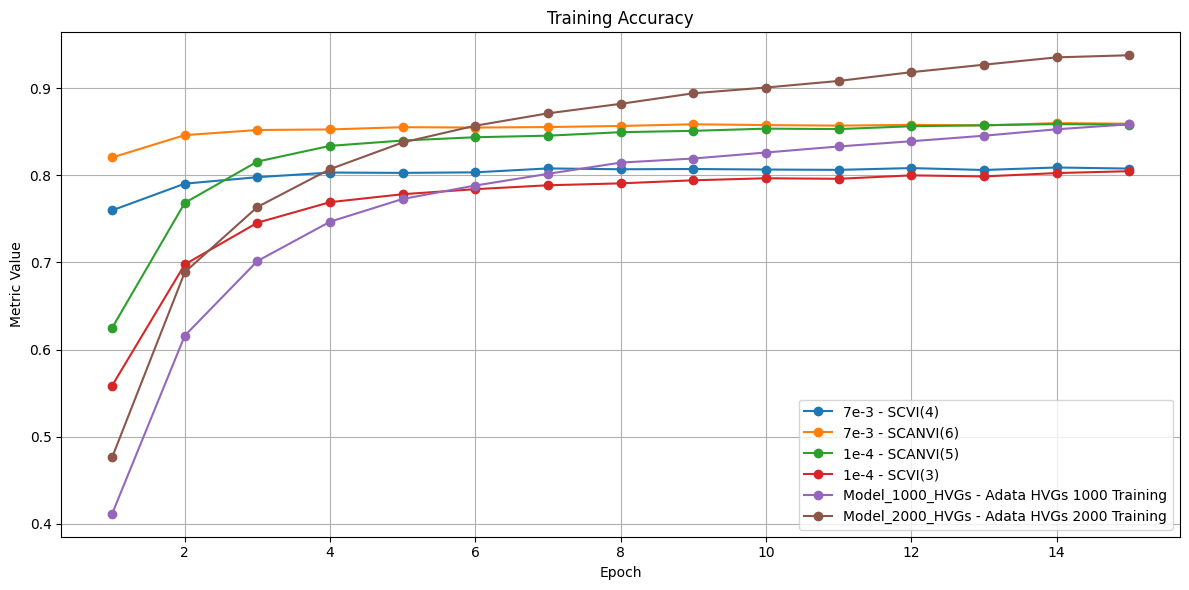

In [ ]:
plot_from_json('Results_JSON/Accuracy_Train.json', "Training Accuracy", xlabel="Epoch", ylabel="Accuracy")

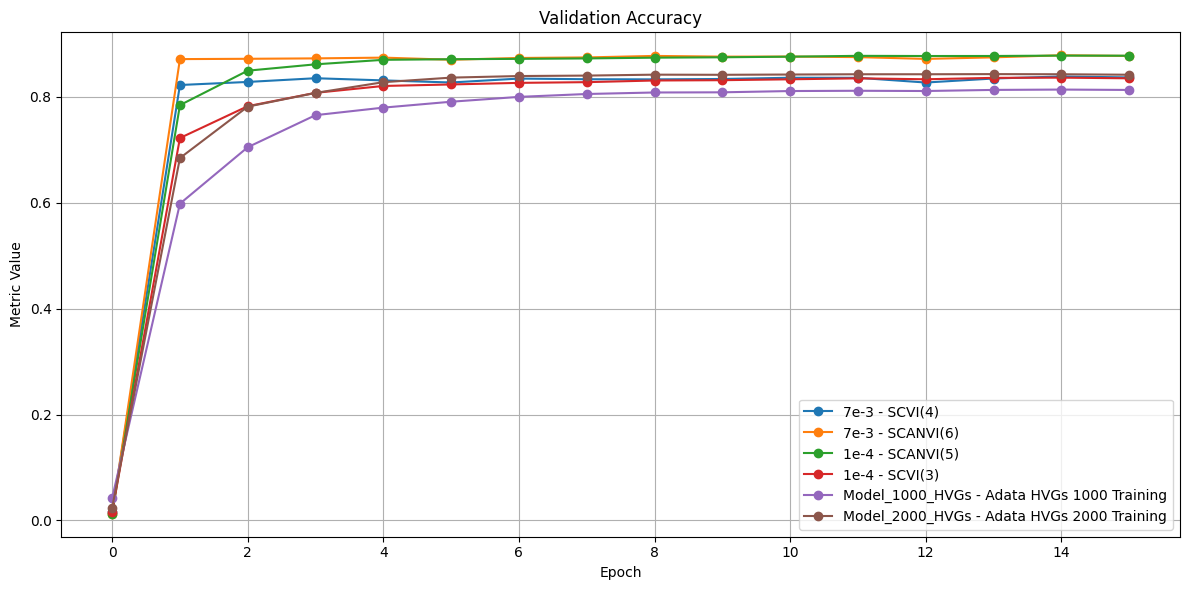

In [ ]:
plot_from_json('Results_JSON/Accuracy_Val.json', "Validation Accuracy", xlabel="Epoch", ylabel="Accuracy")

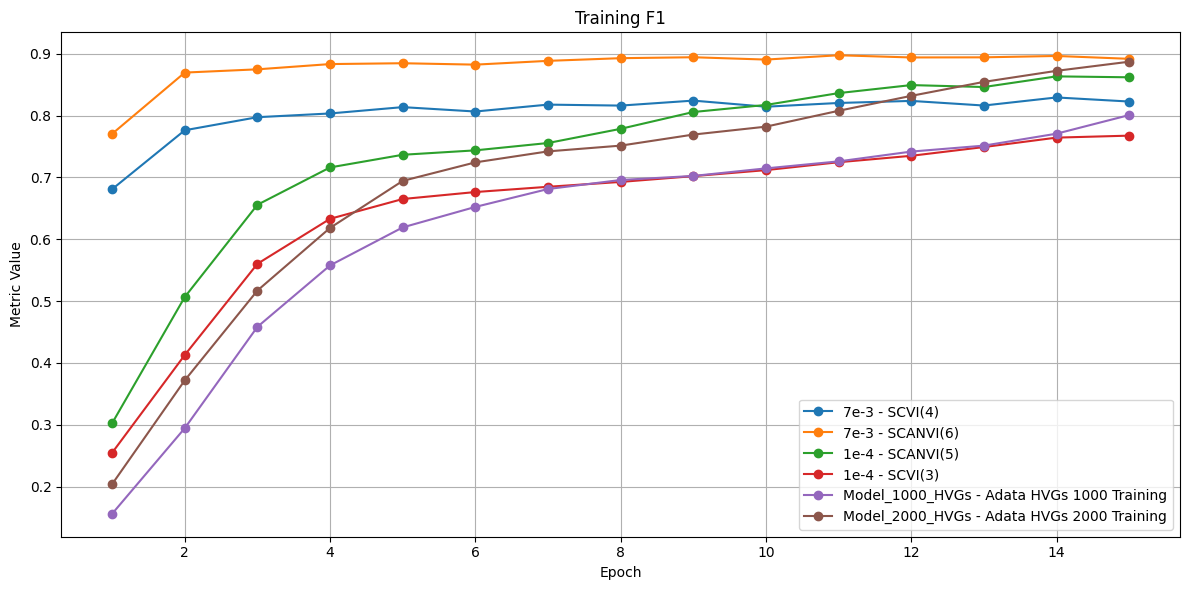

In [ ]:
plot_from_json('Results_JSON/F1_Train.json', "Training F1", xlabel="Epoch", ylabel="F1 Score")

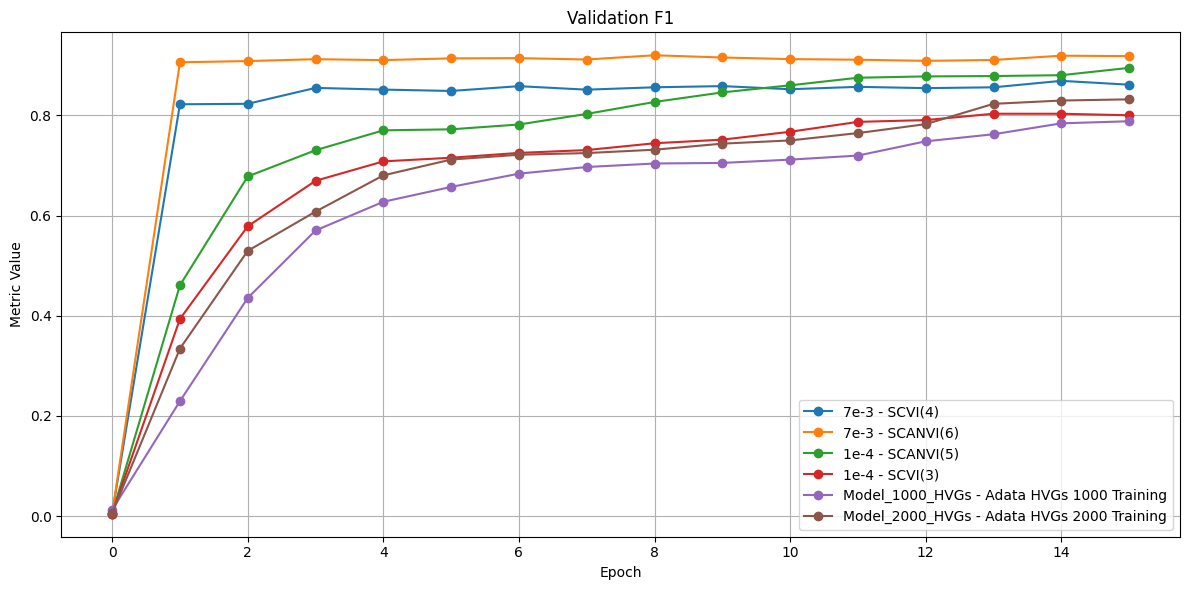

In [ ]:
plot_from_json('Results_JSON/F1_Val.json', "Validation F1", xlabel="Epoch", ylabel="F1 Score")

In [35]:
X_test = raw_adata[cells_test].obsm['X_scANVI']
test_dataset = scRNAseqDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [40]:
import torch
from sklearn.metrics import classification_report

model.eval()
model.to(DEVICE)

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.numpy())

decoded_preds = le.inverse_transform(all_preds)
decoded_targets = le.inverse_transform(all_targets)

report = classification_report(decoded_targets, decoded_preds)

In [41]:
print(report)

                           precision    recall  f1-score   support

           AT2, AT1 cells       1.00      1.00      1.00        26
                  B cells       0.98      1.00      0.99        50
           CD4 CM T cells       0.94      0.91      0.92       554
    CD4 cytotoxic T cells       0.93      0.95      0.94       187
      CD4 prolif. T cells       0.96      0.98      0.97       100
    CD8 cytotoxic T cells       0.90      0.82      0.86       452
CD8 cytotoxic TRM T cells       0.82      0.92      0.87       327
      CD8 prolif. T cells       0.97      0.97      0.97       118
           Ciliated cells       1.00      1.00      1.00       147
        Club, Basal cells       1.00      1.00      1.00        39
                      DC1       0.96      0.99      0.98        81
                      DC2       0.89      1.00      0.94        47
  Infected AT2, AT1 cells       1.00      1.00      1.00         7
                Ionocytes       1.00      1.00      1.00     

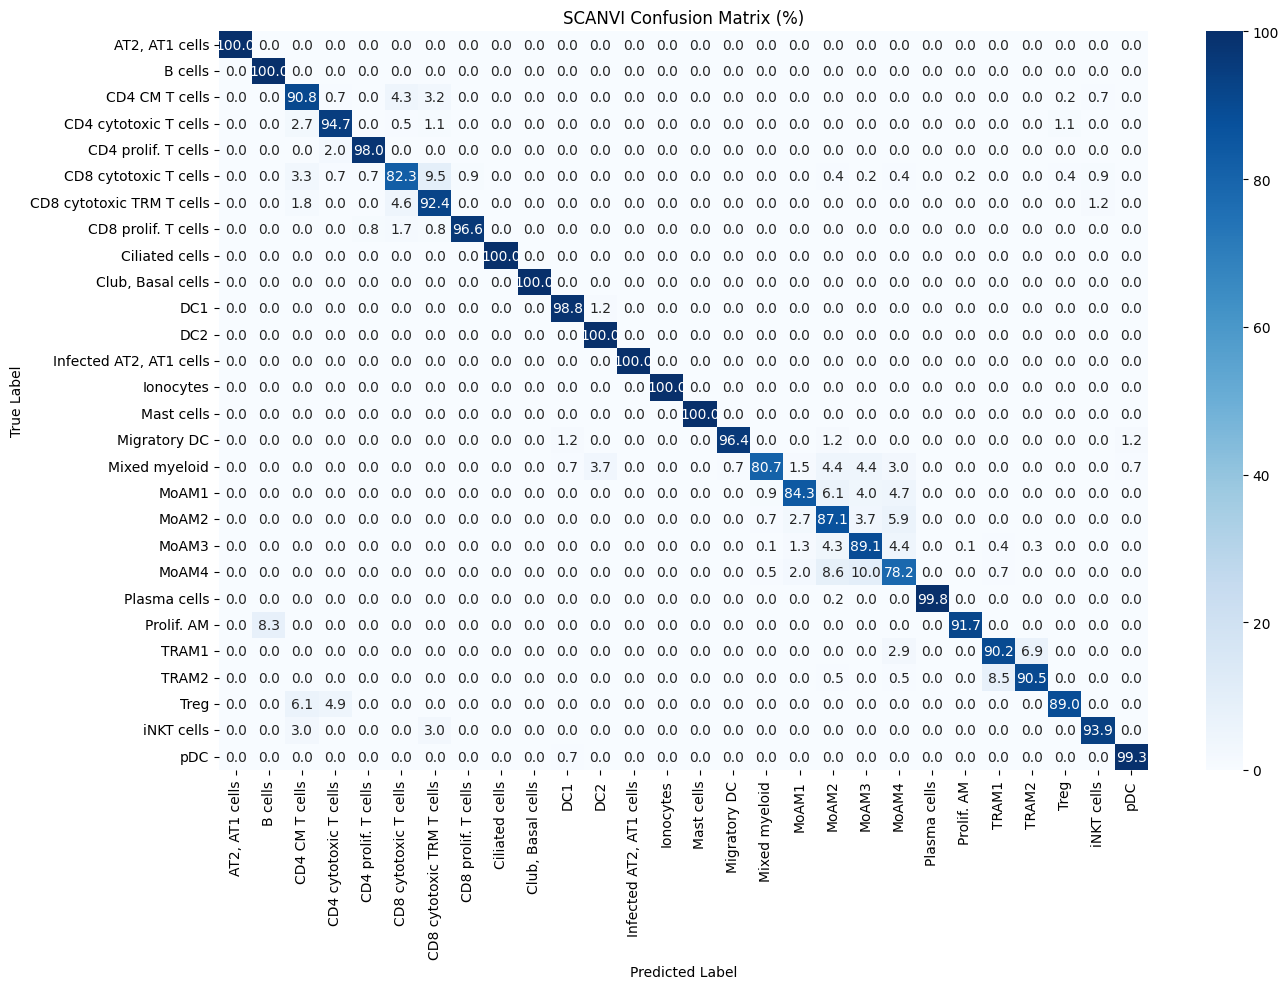

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(decoded_targets, decoded_preds, labels=le.classes_)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # convert to percentage

plt.figure(figsize=(14, 10))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SCANVI Confusion Matrix (%)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
